# 0. Collecting Dataframes
This notebook collects the various intermediate results (FOOOF, structural, and gene data, etc) and compiles them into corresponding dataframes, for both the macaque and human MNI data, separately, to be analyzed/visualized in subsequent notebooks. The human working memory ECoG data is not pre-computed or compiled here, and lives in ./4b_analysis_human_wm

The last section describes how ECoG data is projected from MNI space to HCP-MMP via Gaussian smoothing.

In [1]:
import numpy as np
from scipy import io
import pandas as pd
import os, sys
import nibabel as nib

%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

sys.path.append('../')
import echo_utils

********************************************************************************
         to build the TVTK classes (8.2). This may cause problems.
         Please rebuild TVTK.
********************************************************************************



### Global parameters for which fooof results to load

In [53]:
# collect FOOOF results that were produced under these parameters
win_len, p_cur = '1sec', 'psd_med'
fg_param_to_load = 'knee'

# Collecting Macaque ECoG

In [4]:
# get cortex files for electrode coordinates
chibi_ctx_file = '/Users/rdgao/Documents/data/NeuroTycho/Propofol/GridLocations/20110621KTMD_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_2Dimg/ChibiMap.mat'
george_ctx_file = '/Users/rdgao/Documents/data/NeuroTycho/Propofol/GridLocations/20110112KTMD_Anesthesia+and+Sleep_George_Toru+Yanagawa_mat_2Dimg/GeorgeMap.mat'
ctx_loc = []
for ind, ctx_file in enumerate([chibi_ctx_file, george_ctx_file]):
    ctx_mat = io.loadmat(ctx_file, squeeze_me=True)
    ctx_loc.append(np.array([ctx_mat['X'], ctx_mat['Y']]).T)

In [5]:
# collection
df_savepath = '../data/df_macaque'
df_combined = pd.DataFrame()
col_names = ['patient','cond','pharm', 'session_id', 'chan', 'exp', 'knee', 'tau','log_tau','err', 'r2']

# load fooof results
result_basepath = '/Users/rdgao/Documents/code/research/field-echos/results/neurotycho/rest_anes/'
session_resultpath = np.sort([f+'/' for f in os.listdir(result_basepath) if os.path.isdir(result_basepath+f)])
session_dict = {id:ind for ind, id in enumerate(np.unique([s.split('_')[3] for s in session_resultpath]))}

for s in session_resultpath:
    fooof_folder = result_basepath + s +'/psd/'+win_len+'/fooof/'+p_cur+'/'    
    ff_list = [ff for ff in os.listdir(fooof_folder) if '.json' in ff]
    ff_file = ff_list[np.where([fg_param_to_load in f for f in ff_list])[0][0]] # load specific fooof file
    
    # return fooof fits and convert knee to tau
    fg_aps, fg_pks, fg_err, fg_r2s = echo_utils.return_fg_fits(ff_file, fooof_folder)
    if fg_aps.shape[1]==3:
        knee_freq, knee_tau = echo_utils.convert_knee_val(fg_aps[:,1],fg_aps[:,2])
        knee = fg_aps[:,1]
    else:
        knee_tau = np.zeros_like(fg_aps[:,0])
        knee = np.zeros_like(fg_aps[:,0])
    
    df_data = np.vstack((fg_aps[:,-1], knee, knee_tau, np.log10(knee_tau), fg_err, fg_r2s)).T
    s_spl = s.split('_')
    patient, cond, pharm, session_id = s_spl[7], s_spl[1], s_spl[2], session_dict[s_spl[3]]
    chan = np.arange(len(fg_err))+1
    df_cur = pd.DataFrame(np.hstack((np.repeat(np.array([patient,cond,pharm, session_id])[:,None].T, len(fg_err), axis=0), chan[:,None], df_data))
                 ,columns=col_names)
    df_cur.insert(5,'y', ctx_loc[0 if patient is 'Chibi' else 1][:,0])
    df_cur.insert(6,'z', ctx_loc[0 if patient is 'Chibi' else 1][:,1])

    df_combined = df_combined.append(df_cur, ignore_index=True)

df_combined.columns
df_combined = df_combined.astype({c:str if c in ['patient', 'cond', 'pharm'] else np.float for c in col_names})

# saveout
df_combined.to_csv(df_savepath+'.csv')

../echo_utils.py:59: RuntimeWarning: invalid value encountered in power
  knee_freq = knee**(1./exponent)


# Collecting Human ECoG

In [63]:
thresh_knee_freq = 1.5
    
# load the various data variables, elec loc, etc
basepath = '/Users/rdgao/Documents/data/MNI_rest/'
datafile = basepath + 'WakefulnessMatlabFile.mat'
result_basepath = '/Users/rdgao/Documents/code/research/field-echos/results/MNI_rest/'
df_savepath = '../data/df_human'

data_dict = io.loadmat(datafile, squeeze_me = True) # data file that has all the meta info
region_labels = pd.read_csv(basepath+'/WakefulnessInformation/RegionInformation.csv') # channel labels
patient_info = pd.read_csv(basepath+'/WakefulnessInformation/PatientInformation.csv', index_col=0, names=['gender', 'age'], skiprows=1) # patient labels
region_labels['Region name']=[rl[1:-1] for rl in region_labels['Region name']] # get rid of quotes
print(data_dict.keys())

# load fooof results, use same glboal settings as monkey ECoG
fooof_folder = result_basepath+'/psd/'+win_len+'/fooof/'+p_cur+'/'
print('Loading file: %s'%fooof_folder)
ff_list = [ff for ff in os.listdir(fooof_folder) if '.json' in ff]
ff_file = ff_list[np.where([fg_param_to_load in f for f in ff_list])[0][0]] # load specific fooof file

# return fooof fits and convert knee to tau
fg_aps, fg_pks, fg_err, fg_r2s = echo_utils.return_fg_fits(ff_file, fooof_folder)
if fg_aps.shape[1]==3:
    knee_freq, knee_tau = echo_utils.convert_knee_val(fg_aps[:,1],fg_aps[:,2])
    knee = fg_aps[:,1]
    
    # drop where knee_freq is less than 1Hz because the fit ends at 1Hz
    knee_tau[knee_freq<thresh_knee_freq]=np.nan
    
else:
    knee_tau = np.zeros_like(fg_aps[:,0])
    knee = np.zeros_like(fg_aps[:,0])

# create pandas df and throw everything in there
e_type = np.array(data_dict['ChannelType'], 'c').view(np.uint8)-64.
#patient_info['gender'] = 0 if 'M' else 1
patient_info.replace(['M','F'], [0,1], inplace=True)
df_info = np.vstack((data_dict['Patient'], 
                     patient_info.loc[data_dict['Patient']][['gender', 'age']].values.astype(int).T, 
                     e_type, 
                     data_dict['ChannelPosition'].T, 
                     data_dict['ChannelRegion'])
                   ).T
df_data = np.vstack((fg_aps[:,-1], knee_freq, knee_tau, np.log10(knee_tau), fg_err, fg_r2s)).T
df_combined = pd.DataFrame(np.hstack((df_info,df_data)),columns=['patient','gender','age','etype', 'x','y','z','region','exp', 'knee_freq', 'tau','log_tau','err', 'r2'])

# insert column for x_positive (collapse across L-R axis)
df_combined.insert(5, 'x_pos', np.abs(df_combined['x'].values))

# insert lobe info
df_combined.insert(8, 'lobe', 0)
lobe_id = {val: ind for ind, val in enumerate(region_labels['Lobe'].unique())}
for ind, region in enumerate(region_labels['Region #']):
    df_combined.loc[df_combined['region']==region,'lobe'] = lobe_id[region_labels.loc[ind,'Lobe']]

print('Total electrodes: %i'%len(df_combined))

# drop nans
df_combined.dropna(inplace=True)
df_combined.reset_index(drop=True, inplace=True)
print('Total electrodes after dropping nans: %i'%len(df_combined))

## print some electrode type info and correlation
# print(df_combined.groupby('etype').count()['patient'])
# print(df_combined[['exp','knee','tau','log_tau', 'err', 'r2']].corr('spearman'))

print('Total patients: %i'%len(df_combined['patient'].unique()))
df_combined.to_csv(df_savepath+'.csv')

dict_keys(['__header__', '__version__', '__globals__', 'AgeAtTimeOfStudy', 'ChannelName', 'ChannelPosition', 'ChannelRegion', 'ChannelType', 'Data', 'FacesLeft', 'FacesRight', 'Gender', 'Hemisphere', 'NodesLeft', 'NodesLeftInflated', 'NodesRegionLeft', 'NodesRegionRight', 'NodesRight', 'NodesRightInflated', 'Patient', 'RegionName', 'SamplingFrequency'])
Loading file: /Users/rdgao/Documents/code/research/field-echos/results/MNI_rest//psd/1sec/fooof/psd_med/
Total electrodes: 1772
Total electrodes after dropping nans: 1722
Total patients: 106


../echo_utils.py:63: RuntimeWarning: invalid value encountered in power
  knee_freq = knee**(1./exponent)
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in less


### Save PSD plots

In [64]:
plot_fits = False

if plot_fits: plt.figure(figsize=(5,5))
for win_len_iter in ['1sec', '5sec']:
    for p_cur_iter in ['psd_mean', 'psd_med']:
        # construct channel metainfo and behavioral table
        psd_data = np.load(result_basepath+'/psd/'+win_len_iter+'/psds.npz')

        # load fooof results
        fooof_folder = result_basepath +'/psd/'+win_len_iter+'/fooof/'+p_cur_iter+'/'  
        ff_list = [ff for ff in os.listdir(fooof_folder) if '.json' in ff]

        # plot psds and all fits
        if plot_fits:
            fit_fig_path = utils.makedir(fooof_folder, '/plts/', False)
            f_axis = psd_data['f_axis']
            psds = psd_data[p_cur_iter].T
            fg_labels = [f.split('.')[0][3:] for f in ff_list]
            # grab fgs
            fg_all=[]
            for ff in ff_list:
                fg_dummy = FOOOFGroup()
                fg_dummy.load(fooof_folder+ff)
                fg_all.append(fg_dummy)
            # plot
            for chan in range(psds.shape[0]):
                utils.plot_psd_fits(f_axis, psds, chan, fg_all, fg_labels)
                plt.title('Channel: %i - Region: %i'%(chan, data_dict['ChannelRegion'][chan]))
                fig_name = '/chan%i_reg%i.png'%(chan, data_dict['ChannelRegion'][chan])
                plt.savefig(fit_fig_path+fig_name)
                plt.clf()

---
# Collecting T1w/T2w & gene expression data
T1T2 and gene expression maps projected onto HCP-MMP parcellation are obtained using code from Rudy's repo: https://github.com/rudyvdbrink/Surface_projection

I collect and convert them into dataframes and save as a csv to be included in the project code repo.

ValueError: cannot insert label, already exists

In [18]:
gene_data = pd.read_csv(anat_basepath+'Glasser_data.csv')
myelin_data = pd.read_csv(anat_basepath+'mvals.txt', header=None, names=gene_data.columns[1:])
myelin_data.insert(0, 'Entrez_ID', np.nan)
myelin_data.insert(1, 'label', 'T1T2')
myelin_data

thickness_data = pd.read_csv(anat_basepath+'tvals.txt', header=None, names=gene_data.columns[1:])
thickness_data.insert(0, 'Entrez_ID', np.nan)
thickness_data.insert(1, 'label', 'thickness')
thickness_data

,Entrez_ID,label,L_V1,L_MST,L_V6,L_V2,L_V3,L_V4,L_V8,L_4,...,R_p47r,R_TGv,R_MBelt,R_LBelt,R_A4,R_STSva,R_TE1m,R_PI,R_a32pr,R_p24
0,NaN,thickness,1.9801,2.4648,2.172,2.0203,2.2183,2.3595,2.6884,2.7759,...,2.5275,3.2128,2.6487,2.5723,2.8997,2.8917,2.9095,2.6318,3.0857,3.2241


In [32]:
#import nibabel as ni
# annot_file = '/Users/rdgao/mne_data/MNE-sample-data/subjects/fsaverage/label/lh.HCPMMP1.annot'
# mmp_labels, ctab, mmp_names = ni.freesurfer.read_annot(annot_file)
# region_names = [n[2:-4].decode("utf-8") for n in mmp_names[1:]]

anat_basepath = '/Users/rdgao/Documents/data/GeneMyelin/genome_maps/'
df_savepath = '../data/df_structural'

gene_data = pd.read_csv(anat_basepath+'Glasser_data.csv')
gene_meta = pd.read_csv(anat_basepath+'Homo_sapiens.csv')[['GeneID', 'Symbol']]

# myelin map
myelin_data = pd.read_csv(anat_basepath+'mvals.txt', header=None, names=gene_data.columns[1:])
myelin_data.insert(0, 'Entrez_ID', np.nan)
myelin_data.insert(1, 'label', 'T1T2')

# thickness map
thickness_data = pd.read_csv(anat_basepath+'tvals.txt', header=None, names=gene_data.columns[1:])
thickness_data.insert(0, 'Entrez_ID', np.nan)
thickness_data.insert(1, 'label', 'thickness')

# Homo_sapiens.csv has the updated gene list, which excludes some of the Entrez IDs in Glasser_data.csv since 
# the publication of Gryglewski et al. 2018, so I prune them here and align labels and data into the same df.
gene_labels = ['' for i in range(len(gene_data))]
g_ids = gene_data['Entrez_ID'].tolist()
for i_r, row in gene_meta.iterrows():
    gene_labels[g_ids.index(row['GeneID'])] = row['Symbol']

# insert label into gene data df
gene_data.insert(1, 'label', gene_labels)
# drop rows where Entrez_ID was not found in the metadata
gene_data = gene_data.drop(index=np.where(gene_data['label']=='')[0])
# combine dataframes
df_struct = pd.concat((myelin_data, thickness_data, gene_data), ignore_index=True)
df_struct.set_index('label', inplace=True)

# save combined to csv
df_struct.to_csv(anat_basepath+'struct_full.csv')

# drop entrez ID column for ease of operation after
df_struct.drop('Entrez_ID', axis=1, inplace=True)

In [33]:
# get the gene ID to symbol conversion table because GOATOOLS will require it later
gene_meta = pd.read_csv(anat_basepath+'Homo_sapiens.csv')[['GeneID', 'Symbol', 'Synonyms']]
gene_meta.to_csv('../data/df_human_geneinfo.csv')

In [34]:
# check consistency of labeling between L & R hemisphere, and compute correlation
regions_L = [l[2:] for l in df_struct.columns[0:180]]
regions_R = [l[2:] for l in df_struct.columns[180:]]
print(regions_L==regions_R)
LR_corr = [pearsonr(row[0:180], row[180:])[0] for i_r, row in df_struct.iterrows()]

True


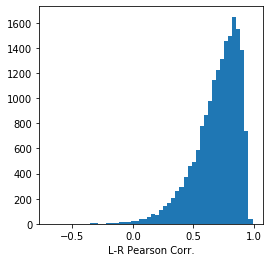

In [35]:
plt.figure(figsize=(4,4))
plt.hist(LR_corr, 50)
plt.xlabel('L-R Pearson Corr.');

On average, correlation is pretty high between L and R hemisphere, but not as close to 1 as I expected. Could use L or R, or hemisphere average. 

In [36]:
# save out but transpose so columns are features
arr_struct = df_struct.values
df_struct_L = pd.DataFrame(arr_struct[:,:180], index=df_struct.index, columns=regions_L).T
df_struct_L.to_csv(df_savepath+'_L.csv')
df_struct_R = pd.DataFrame(arr_struct[:,180:], index=df_struct.index, columns=regions_R).T
df_struct_R.to_csv(df_savepath+'_R.csv')
df_struct_avg = pd.DataFrame((arr_struct[:,:180]+arr_struct[:,180:])/2, index=df_struct.index, columns=regions_L).T
df_struct_avg.to_csv(df_savepath+'_avg.csv')

---
# Aligning ECoG (MNI) and Structural (Glasser) data
The ECoG electrode locations are given in (volumetric) MNI space, where as the myelination & expression data are given for surface Glasser parcellation. To compare the two datasets, and in general visualizing the ECoG data spatially, we have to align them to the same space.

This can be done either through discrete assignments (1-to-1 or N-to-1), or upsampling into a common space and then smooth & aggregate back into either MNI or Glasser space.

In [66]:
MMP_data = nib.load(anat_basepath+'MMP 1.0 MNI projections/MMP_in_MNI_symmetrical_1.nii.gz')

# since only <4% of voxels actually have non-zero parcellation values
# we can reduce the map first and just search in the non-zero regions
# reduce the map and find the indices where parcel value is non-zero
MMP_map = np.asarray(MMP_data.get_data())
MMP_sparse_coords = np.array(np.where(MMP_map>0)).T
MMP_map_sparse_flat = MMP_map[np.where(MMP_map>0)]

# r_search = 3
# # transform to MMP indices
# ecog_coors_transformed = np.array([echo_utils.apply_affine(MMP_data.affine, row[['x','y','z']].values, False) for r_i, row in df_combined.iterrows()])

# # find the closest projection of ecog onto parcellation voxels within a radius
# proj_dist_inds = echo_utils.project_ecog_mmp(ecog_coors_transformed, MMP_sparse_coords, r_search, find_nearest=False)

### Upsample, Smoothing & Project to MMP
Here, we create a electrode distance-weighted map for each subject that's a function of a Gaussian where the weight drops to 50% at distance d. The weight is computed at every MNI-coordinate value at which there is an MMP parcel. The distance-weighted feature matrix (in this case, tau) is then computed as a weighted sum over all electrodes and grouped at the parcel level. This has two advantages: 1) electrodes near parcellation boundaries still contribute to the nearby parcels even if it doesn't fall within it, and 2) electrodes in the center of a parcellation contribute more to the parcel's value than electrodes at boundaries. 

W_sum and W_max record the sum and max of the weight within each parcel for every subject, as a measure of confidence of the largest contribution (how close the closest electrode is) that fell within the parcel.

Original MATLAB code & idea for spatial smoothing with Gaussian courtesy of discussion with Thomas Pfeffer.

In [67]:
df_combined = pd.read_csv('../data/df_human.csv', index_col=0)

# set smoothing parameter: Gaussian is at 50% when d voxels away
d = 4
d_alpha= d/(-np.log(0.5))**0.5

output_grid = MMP_sparse_coords
feature = 'tau'
feat_weighted, W_sum, W_max = [],[],[]
for i_p in np.unique(df_combined['patient']):
    # iterate over patients
    print(int(i_p), end='|')
    df_patient = df_combined[df_combined['patient']==i_p]
    
    # get transformed ECoG coordinate
    input_grid = np.array([echo_utils.apply_affine(MMP_data.affine, row[['x','y','z']].values, False) for r_i, row in df_patient.iterrows()])    

    # create the weight matrix from input to output projection based on Gaussian weighting of Euclidean distance
    W_mat = np.zeros((input_grid.shape[0],output_grid.shape[0]))
    for ig in range(input_grid.shape[0]):
        W_mat[ig,:] = np.exp(-np.linalg.norm(output_grid-input_grid[ig,:], axis=1)**2/d_alpha**2)

    # get total and max weights to drop bad coverage points
    W_sum.append(W_mat.sum(0)) 
    W_max.append(np.max(W_mat,0))
    feat_weighted.append(np.dot(df_patient[feature].values, W_mat)/W_mat.sum(0))
    

1|2|3|4|5|6|7|8|9|10|11|

/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|34|35|36|37|38|39|40|41|42|43|44|45|46|47|48|49|50|52|53|54|55|56|57|58|59|60|61|62|63|64|65|66|67|68|69|70|71|72|73|74|75|76|77|78|79|80|81|82|83|84|85|87|88|89|90|91|92|93|94|96|97|98|99|100|101|102|103|104|106|107|108|109|110|

In [68]:
# save parcellated feature matrix
df_save = pd.DataFrame(np.array(feat_weighted).T, columns=np.unique(df_combined['patient']).astype(int))
df_save.insert(0, 'parcel', MMP_map_sparse_flat)
df_save.groupby('parcel').mean().T.to_csv('../data/df_human_%s_weighted_%i.csv'%(feature, d), header=region_names)

# save parcellated weight matrix sum
df_save = pd.DataFrame(np.array(W_sum).T, columns=np.unique(df_combined['patient']).astype(int))
df_save.insert(0, 'parcel', MMP_map_sparse_flat)
df_save.groupby('parcel').sum().T.to_csv('../data/df_human_W_sum_%i.csv'%d, header=region_names)

# save parcellated weight matrix max
df_save = pd.DataFrame(np.array(W_max).T, columns=np.unique(df_combined['patient']).astype(int))
df_save.insert(0, 'parcel', MMP_map_sparse_flat)
df_save = df_save.groupby('parcel').max().T.to_csv('../data/df_human_W_max_%i.csv'%d, header=region_names)

### Grab brain-specfic genes

In [50]:
# import mygene for parsing ENSEMBL to entrez 
# https://pypi.org/project/mygene/

# how do I cite this??
import mygene
mg = mygene.MyGeneInfo()

# table from Fagerberg et al. 2014: https://www.mcponline.org/content/13/2/397.long
df_gene_body = pd.read_excel('../data/mcp.M113.035600-2.xlsx', index_col=0) 

#last column is category note
df_gene_body = df_gene_body[df_gene_body.columns[:-1]]

# genes expressed 4X greater in the brain than the median across all genes are considered "brain genes"
# same as done in Burt 2018, where they follow Genovese et al. 2016: https://www.nature.com/articles/nn.4402
brain_genes = df_gene_body[df_gene_body['brain']>df_gene_body.median(axis=1)*4].index.to_list()

# query
brain_genes_id = [mg.getgene(g, ['_id', 'symbol']) for g in brain_genes]

In [81]:
df_brain_genes = pd.DataFrame([[g['_id'], g['symbol']] for g in brain_genes_id if g is not None], columns=['GeneID', 'symbol'])

# drop columns where no Entrez ID is found and save out
df_brain_genes[~df_brain_genes['GeneID'].str.contains("ENS")].to_csv('../data/df_brain_genes.csv')